In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt

In [7]:
# Load and preprocess the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
def create_lagged_features(data, columns, lag=30):
    """
    Generate lagged features for time series prediction for specified columns.
    """
    lagged_columns = {}  # Use a dictionary to collect all lagged columns
    for col in columns:
        for i in range(1, lag + 1):
            lagged_columns[f'{col}_Lag_{i}'] = data[col].shift(i)

    # Combine the original DataFrame with lagged columns
    lagged_df = pd.concat([data, pd.DataFrame(lagged_columns, index=data.index)], axis=1)
    lagged_df.dropna(inplace=True)  # Drop rows with NaN values (due to lagging)
    
    return lagged_df

# Use multiple features for lagging
lagged_df = create_lagged_features(df, columns=['Adj Close', 'Volume', 'High', 'Low'], lag=30)
X = lagged_df.drop(columns=['Adj Close']).values
y = lagged_df['Adj Close'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Time Series Cross-Validation 
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [0.5, 1.0]
}

# Pre-tune XGBoost hyperparameters using GridSearchCV on full training set
split_idx = int(len(X_scaled) * 0.8)
X_train_full, y_train_full = X_scaled[:split_idx], y[:split_idx]
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=10,
    learning_rate=0.05,
    n_estimators=200,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
)

optimized_xgb_model = xgb_model.fit(X_train_full, y_train_full)

In [9]:
# Cross-validation evaluation for all models
xgb_mae = []
xgb_rmse = []
xgb_r2 = []
fold = 1

for train_idx, test_idx in tscv.split(X):
    # Train-test split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Apply scaling only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    optimized_xgb_model.fit(X_train_scaled, y_train)
    xgb_pred = optimized_xgb_model.predict(X_test_scaled)
    xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
    xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
    xgb_r2.append(r2_score(y_test, xgb_pred))

    print(f"Fold {fold}:")
    print(f"  XGBoost - MAE={xgb_mae[-1]:.2f}, RMSE={xgb_rmse[-1]:.2f}, R2={xgb_r2[-1]:.4f}")
    fold += 1

# Average metrics across folds
print("\nCross-Validation Results (Average):")
print(f"XGBoost - MAE: {np.mean(xgb_mae):.2f}, RMSE: {np.mean(xgb_rmse):.2f}, R2: {np.mean(xgb_r2):.4f}")

Fold 1:
  XGBoost - MAE=1.59, RMSE=2.40, R2=0.9998
Fold 2:
  XGBoost - MAE=2.62, RMSE=8.63, R2=0.9982
Fold 3:
  XGBoost - MAE=240.23, RMSE=321.34, R2=-0.2589
Fold 4:
  XGBoost - MAE=513.29, RMSE=610.46, R2=-2.2531
Fold 5:
  XGBoost - MAE=1056.08, RMSE=1225.11, R2=-2.7736

Cross-Validation Results (Average):
XGBoost - MAE: 362.76, RMSE: 433.59, R2: -0.6575


In [10]:
# Final Evaluation on Test Set
# Train-test split for final evaluation
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# XGBoost
optimized_xgb_model.fit(X_train, y_train)
xgb_pred = optimized_xgb_model.predict(X_test)

In [11]:
# Final evaluation metrics
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

# 1% Error Check
xgb_accuracy = [abs((pred - actual) / actual) <= 0.01 for pred, actual in zip(xgb_pred, y_test)]
xgb_accuracy_rate = sum(xgb_accuracy) / len(xgb_accuracy) * 100

# Print final evaluation metrics
print("\nFinal Evaluation on Test Set:")
print(f"XGBoost - Accuracy (within 1% error): {xgb_accuracy_rate:.2f}%")
print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R2: {xgb_r2:.4f}")


Final Evaluation on Test Set:
XGBoost - Accuracy (within 1% error): 6.66%
XGBoost - MAE: 1178.06, RMSE: 1395.63, R2: -2.2723


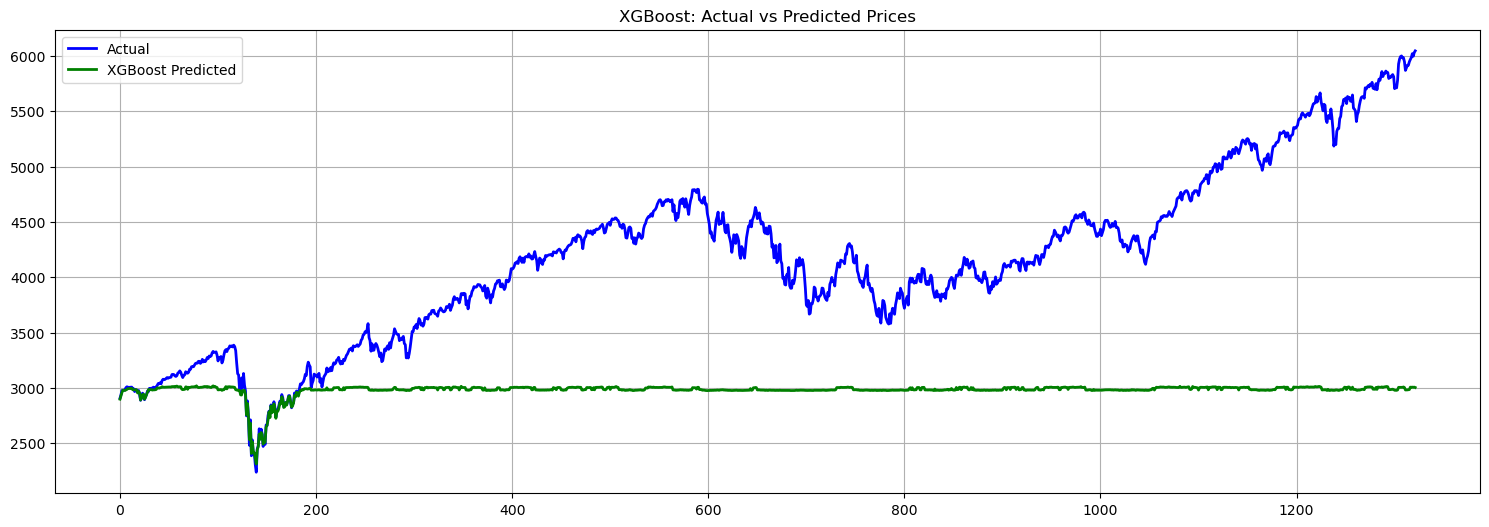

In [12]:
# Visualization
plt.figure(figsize=(15, 20))

# XGBoost: Actual vs Predicted
plt.subplot(4, 1, 2)
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', linewidth=2)
plt.plot(range(len(xgb_pred)), xgb_pred, label='XGBoost Predicted', color='green', linewidth=2)
plt.title(f'XGBoost: Actual vs Predicted Prices')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


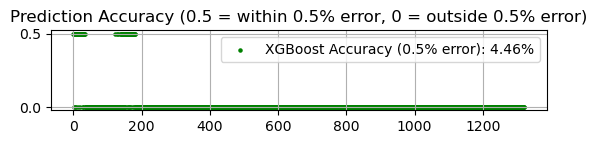

In [13]:
# Calculate accuracy within 0.5%
def accuracy_within_threshold(y_actual, y_predicted, threshold=0.005):
    within_threshold = np.abs((y_actual - y_predicted) / y_actual) <= threshold
    accuracy = np.sum(within_threshold) / len(y_actual) * 100
    return accuracy

# Compute accuracy within 0.5%
accuracy_05 = accuracy_within_threshold(y_test, xgb_pred, threshold=0.005)

# 0.5% Error Accuracy Plot
plt.subplot(4, 1, 4)
xgb_accuracy_plot = [0.5 if abs((p - a) / a) <= 0.005 else 0 for p, a in zip(xgb_pred, y_test)]

plt.scatter(range(len(xgb_accuracy_plot)), xgb_accuracy_plot, label=f'XGBoost Accuracy (0.5% error): {accuracy_05:.2f}%', color='green', s=5)
plt.title('Prediction Accuracy (0.5 = within 0.5% error, 0 = outside 0.5% error)')
plt.legend()
plt.grid(True)
plt.show()